In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AutoReg

## load Liestal data

In [3]:
train = pd.read_csv('Liestal.csv')
train['doy'] = pd.to_datetime(train['DATE']).dt.dayofyear
print(train.shape)
train.head()

(44042, 16)


,location,lat,long,alt,year,bloom_date,bloom_doy,DATE,PRCP,SNWD,TAVG,TMAX,TMIN,Status,CDD,doy
0,liestal,47.4814,7.730519,350,1901,1901-04-23,113,1901-01-01,2.2,NaN,3.429093,7.5,-1.0,0,3.429093,1
1,liestal,47.4814,7.730519,350,1901,1901-04-23,113,1901-01-02,2.5,NaN,-2.071414,0.0,-4.0,0,1.357679,2
2,liestal,47.4814,7.730519,350,1901,1901-04-23,113,1901-01-03,0.0,NaN,-5.265217,-3.0,-7.0,0,-3.907539,3
3,liestal,47.4814,7.730519,350,1901,1901-04-23,113,1901-01-04,0.0,NaN,-8.153870,-4.5,-11.5,0,-12.061409,4
4,liestal,47.4814,7.730519,350,1901,1901-04-23,113,1901-01-05,0.0,NaN,-9.589825,-5.5,-13.5,0,-21.651234,5


In [5]:
train.describe()

,lat,long,alt,year,bloom_doy,PRCP,SNWD,TAVG,TMAX,TMIN,Status,CDD,doy
count,4.404200e+04,4.404200e+04,44042.0,44042.000000,44042.000000,44042.000000,33003.000000,44042.000000,44042.000000,44042.000000,44042.000000,44042.000000,44042.000000
mean,4.748140e+01,7.730519e+00,350.0,1960.792244,101.189773,2.190902,3.827591,10.178871,14.841138,5.882657,0.724876,1726.704552,182.756414
std,2.403083e-11,3.485252e-12,0.0,34.809517,10.969568,4.873981,20.666324,7.414925,8.841784,6.591264,0.446582,1391.952946,105.404934
min,4.748140e+01,7.730519e+00,350.0,1901.000000,75.000000,-0.138916,0.000000,-18.524698,-14.300000,-24.100000,0.000000,-280.703641,1.000000
25%,4.748140e+01,7.730519e+00,350.0,1931.000000,92.000000,0.000000,0.000000,4.500000,7.900000,1.000000,0.000000,314.305877,91.250000
50%,4.748140e+01,7.730519e+00,350.0,1961.000000,102.000000,0.000000,0.000000,10.400000,15.000000,6.000000,1.000000,1557.874266,182.000000
75%,4.748140e+01,7.730519e+00,350.0,1991.000000,109.000000,2.100000,0.000000,16.131125,21.800000,11.200000,1.000000,3138.681836,274.000000
max,4.748140e+01,7.730519e+00,350.0,2021.000000,124.000000,85.000000,550.000000,29.600000,39.000000,22.400000,1.000000,4485.358433,366.000000


## $\log{\frac{P_t}{1-P_t}} = \beta_0 + \beta_1 t + \beta_2 \text{CDD}_t$

## $\text{CDD}_t = \sum_{i=1}^{t}T $

## plot lower and upper bound

In [6]:
# return the upper and lower bound near p_doy, from year start to year end
def p_doy_bound(start, end):
    
    # return upper, lower, beta0, beta1, beta2
    upper = np.zeros(end - start + 1)
    lower = np.zeros(end - start + 1)
    beta0 = np.zeros(end - start + 1)
    beta1 = np.zeros(end - start + 1)
    beta2 = np.zeros(end - start + 1)
    
    for year in range(start, end + 1):
        year_str = str(year)
        
        # create data column
        train_year = train[train['year'] == year][:180]
        features = ['doy', 'CDD']
        X = train_year[features]
        y = train_year.Status
        
        # fitting
        pred_model = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
        pred_model.fit(X, y)
        beta = pred_model.coef_
        
        # get probability vs. doy function
        p_days = np.array(1 / (1 + np.exp(- np.matmul(X, beta.T) - pred_model.intercept_)))
        
        # get upper and lower bound
        day_bloom = int(np.array(train_year['bloom_doy'])[0])
        for i in range(0, 180):
            if p_days[i + 1, 0] > 0.5:
                lower[year - start] = p_days[i, 0]
                upper[year - start] = p_days[i + 1, 0]
                break
                
        beta0[year - start] = pred_model.intercept_[0]
        beta1[year - start] = beta[0, 0]
        beta2[year - start] = beta[0, 1]
        
    return upper, lower, beta0, beta1, beta2

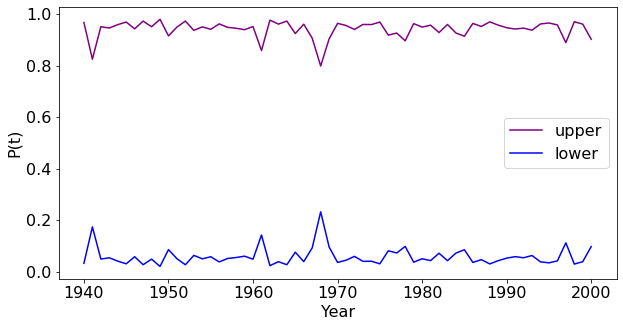

In [7]:
# plot the upper, lower bound vs. year
start = 1940
end = 2000
result = p_doy_bound(start, end)
# result[0]: upper
# result[1]: lower
# result[2]: beta0
# result[3]: beta1
# result[4]: beta2
x = np.arange(start, end + 1)

plt.figure(figsize=(10, 5))
plt.plot(x, result[0], color = 'purple', label = 'upper')
plt.plot(x, result[1], color = 'blue', label = 'lower')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("P(t)", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

avg =  -216.48127479152282
std =  59.83766724367198


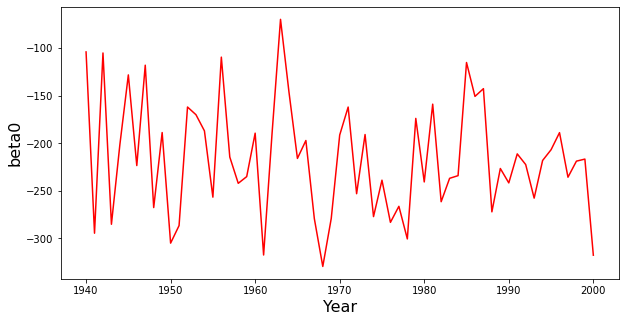

avg =  0.06108129018674741
std =  0.04050188745609047


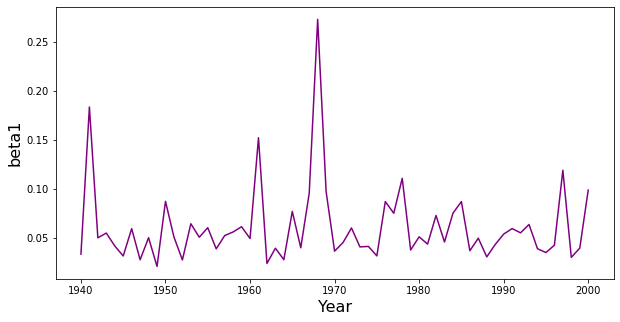

avg =  0.5511243324975849
std =  0.07898231644782477


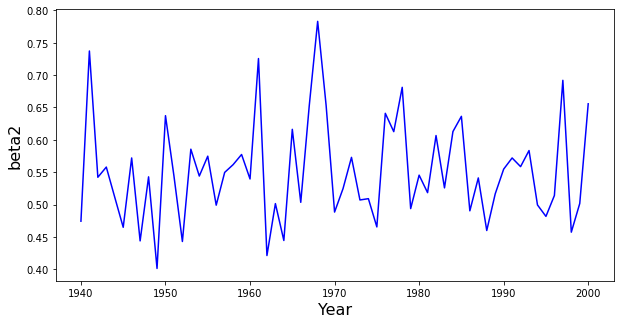

In [8]:
start = 1940
end = 2000
result = p_doy_bound(start, end)
# print("beta_0: ", result[2])
# print("beta_1: ", result[3])
# print("beta_2: ", result[4])
x = np.arange(start, end + 1)

plt.figure(figsize=(10, 5))
plt.plot(x, result[2], color = 'red')
print("avg = ", np.average(result[2]))
print("std = ", np.std(result[2]))
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta0", fontsize = 16)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x, result[3], color = 'purple')
print("avg = ", np.average(result[3]))
print("std = ", np.std(result[3]))
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta1", fontsize = 16)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x, result[4], color = 'blue')
print("avg = ", np.average(result[4]))
print("std = ", np.std(result[4]))
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta2", fontsize = 16)
plt.show()

## $\beta_i$ time series

### $\beta_0, \beta_1, \beta_2$ lag plot

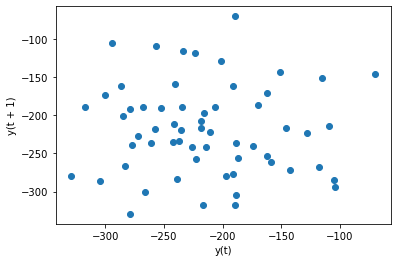

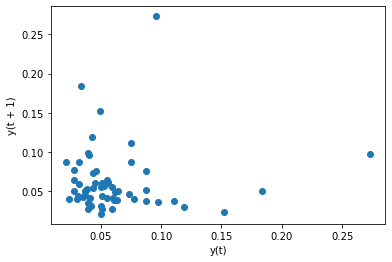

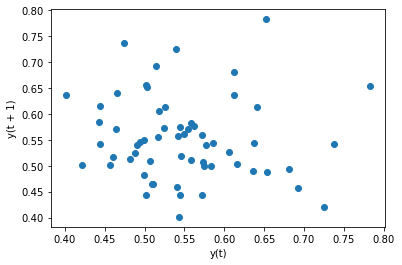

In [9]:
lag_plot(pd.Series(result[2]), lag=1)
plt.show()
lag_plot(pd.Series(result[3]), lag=1)
plt.show()
lag_plot(pd.Series(result[4]), lag=1)
plt.show()

### $\beta_0, \beta_1, \beta_2$ Autocorrection plot

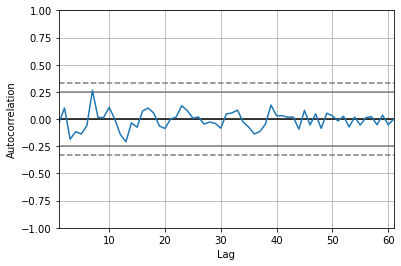

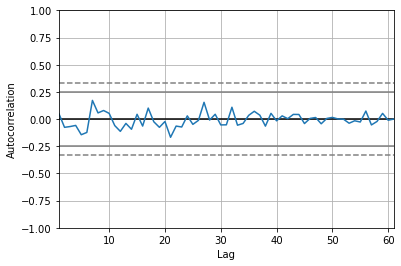

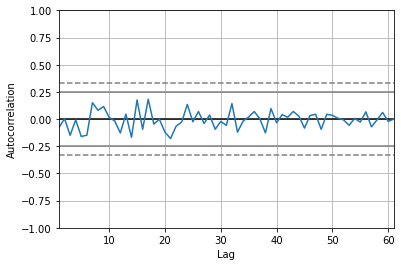

In [10]:
autocorrelation_plot(result[2])
plt.show()
autocorrelation_plot(result[3])
plt.show()
autocorrelation_plot(result[4])
plt.show()

## time series prediction - AutoReg

In [11]:
beta0_model = AutoReg(result[2], lags = 5).fit()
beta0_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                   61
Model:                     AutoReg(5)   Log Likelihood                -303.777
Method:               Conditional MLE   S.D. of innovations             54.907
Date:                Sat, 26 Feb 2022   AIC                              8.261
Time:                        23:27:27   BIC                              8.514
Sample:                             5   HQIC                             8.359
                                   61                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -292.3326     65.542     -4.460      0.000    -420.793    -163.873
y.L1           0.0699      0.136      0.512      0.609      -0.198       0.337
y.L2          -0.0070      0.135     -0.052      0.958      -0.271       0.257
y.L3          -0.1513      0.127     -1.187      0.235      -0.401       0.099
y.L4          -0.1293      0.127     -1.018      0.309      -0.378       0.120
y.L5          -0.1267      0.126     -1.009      0.313      -0.373       0.119
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9462           -0.8789j            1.2914           -0.1191
AR.2            0.9462           +0.8789j            1.2914            0.1191
AR.3           -1.6091           -0.0000j            1.6091           -0.5000
AR.4           -0.6518           -1.5860j            1.7147           -0.3121
AR.5           -0.6518           +1.5860j            1.7147            0.3121
-----------------------------------------------------------------------------
"""

## Compare the $\beta_i$

In [12]:
start = 1940
end = 2000
result_val = p_doy_bound(2001, 2021)

## $p$ value:
$\beta_0$: 9

$\beta_1$: 2

$\beta_2$: 13

In [13]:
result[2]

array([-103.92455799, -294.52843057, -105.02583126, -285.11795134,
       -201.26298549, -128.07109536, -223.3876718 , -117.87321353,
       -267.55467671, -188.674747  , -304.94498431, -286.51697576,
       -161.85858254, -169.93550683, -186.89165297, -256.59553955,
       -109.38983706, -214.4403856 , -242.05226433, -235.00194875,
       -189.31689929, -317.41751787, -189.52235236,  -69.67243005,
       -146.12119237, -215.8882806 , -197.05387188, -279.179903  ,
       -329.45497664, -278.98465553, -191.27460618, -161.87561837,
       -252.98286964, -190.76313801, -277.04913353, -238.76340598,
       -283.10329418, -266.24909359, -300.51359807, -173.80817889,
       -240.60452601, -158.83146839, -261.39926353, -236.79833236,
       -233.99683391, -115.04440206, -150.68473823, -142.54295126,
       -272.05176383, -226.47651401, -241.61391276, -211.11383235,
       -222.34491469, -257.62795757, -218.04199332, -206.75451607,
       -188.76991972, -235.63554051, -218.75121048, -216.58504

In [14]:
result_val[2]

array([-320.62979227, -194.53163389, -217.02277686, -176.06922828,
       -183.92959856, -141.0060607 , -401.76766727, -254.5268341 ,
       -155.29359934, -155.61654944, -217.81710138, -199.84942001,
       -135.73607498, -390.32708896, -224.55902979, -267.55513465,
       -189.28831045, -197.29986574, -293.95713078, -243.98833264,
       -223.15178402])

In [15]:
result[3]

array([0.03356544, 0.18377499, 0.05022841, 0.05507078, 0.04192469,
       0.03166829, 0.05958432, 0.02779254, 0.05033809, 0.02099622,
       0.08743449, 0.0510778 , 0.0276315 , 0.0645633 , 0.0508138 ,
       0.06054927, 0.03896281, 0.05248077, 0.05621652, 0.06157439,
       0.04950606, 0.15238636, 0.02400185, 0.0396062 , 0.0278742 ,
       0.07716966, 0.04004298, 0.09557872, 0.27321776, 0.09730921,
       0.03662268, 0.04538179, 0.06029757, 0.04097287, 0.04143413,
       0.03178589, 0.0872348 , 0.07529337, 0.1109174 , 0.0377892 ,
       0.05124592, 0.04377536, 0.07302355, 0.04594197, 0.07530622,
       0.08719847, 0.03701774, 0.04986602, 0.03076298, 0.04340079,
       0.05400387, 0.05962986, 0.05530548, 0.06383939, 0.03908978,
       0.03515927, 0.04268121, 0.11920555, 0.03024785, 0.03967067,
       0.0989156 ])

In [16]:
result_val[3]

array([0.08232559, 0.04134552, 0.0906428 , 0.040929  , 0.05290861,
       0.03032409, 0.09542057, 0.05830186, 0.02854439, 0.04137081,
       0.04511482, 0.06151442, 0.02191836, 0.17542972, 0.03716739,
       0.0442496 , 0.05684315, 0.02571533, 0.12282776, 0.04633847,
       0.06324127])

In [17]:
result[4]

array([0.47420432, 0.73713198, 0.54207635, 0.5578151 , 0.51116005,
       0.4648027 , 0.57190713, 0.44379185, 0.54271811, 0.40122521,
       0.63721952, 0.54418318, 0.44284875, 0.5854388 , 0.54396359,
       0.57466522, 0.49897612, 0.54957321, 0.56157157, 0.57725448,
       0.53943738, 0.72547413, 0.42117428, 0.50137598, 0.44440223,
       0.61613171, 0.50335952, 0.6519461 , 0.78291025, 0.65306289,
       0.48831505, 0.52452921, 0.57281908, 0.50701101, 0.50900408,
       0.46535544, 0.64085962, 0.61253224, 0.68100148, 0.49366012,
       0.54534059, 0.51829557, 0.60651817, 0.52566885, 0.61268416,
       0.63619405, 0.49024703, 0.54103851, 0.45984399, 0.51641278,
       0.5546334 , 0.57190469, 0.55850845, 0.58333629, 0.49931903,
       0.48163519, 0.51388384, 0.69182788, 0.45726491, 0.50159221,
       0.65554564])

In [18]:
result_val[4]

array([0.62649052, 0.50861855, 0.64568325, 0.50712884, 0.5503824 ,
       0.45770357, 0.64997831, 0.56827195, 0.4480614 , 0.50875523,
       0.52332432, 0.57732388, 0.40758305, 0.75129745, 0.49068298,
       0.52064346, 0.5630547 , 0.43181712, 0.6899948 , 0.52812693,
       0.58172909])

## Validation 2001 - 2000

In [27]:
beta0_model = AutoReg(result[2], lags = 10, trend='c').fit()
beta1_model = AutoReg(result[3], lags = 18, trend='c').fit()
beta2_model = AutoReg(result[4], lags = 5, trend='c').fit()
# validate the blooming doy
# return the predicted doy and the real doy
def predict_blooming_beta_ts(start, end):
    
    training_start = 1940
    
    predict = np.zeros(end - start + 1)
    real = np.zeros(end - start + 1)
    
    L_train = len(result[2])
    
    beta0_pre = beta0_model.predict(start-training_start, end-training_start, dynamic=False)
#     beta0_pre = np.array([np.median(result[2])] * (end - start + 1))
    beta1_pre = beta1_model.predict(start-training_start, end-training_start, dynamic=False)
    beta2_pre = beta2_model.predict(start-training_start, end-training_start, dynamic=False)
    
    for year in range(start, end + 1):
        year_str = str(year)
        
        # build the real doy array
        CU = np.average(train[train['year'] == year - 1][-71:]['TAVG'])
        train_year = train[train['year'] == year][:180]
        real[year - start] = int(np.array(train_year['bloom_doy'])[0])
        
        features = ['doy', 'CDD']
        X = train_year[features]
        y = train_year.Status
        
        # time series predict beta_i
        b = np.array([[beta1_pre[year - start], beta2_pre[year - start]]])
#         b0 = np.array([beta0_pre[year - start]])
#         if CU < 9:
#             b0 = np.array([beta0_pre[year - start] + 50])
        if CU > 6.5:
            b0 = np.array([beta0_pre[year - start] - 50])
        else:
            b0 = np.array([beta0_pre[year - start]])
        
        p_days = np.array(1 / (1 + np.exp(- np.matmul(X, b.T) - b0)))
        
        for i in range(180):
            if p_days[i, 0] > 0.5:
                predict[year - start] = i + 1
                break
        
    return predict, real


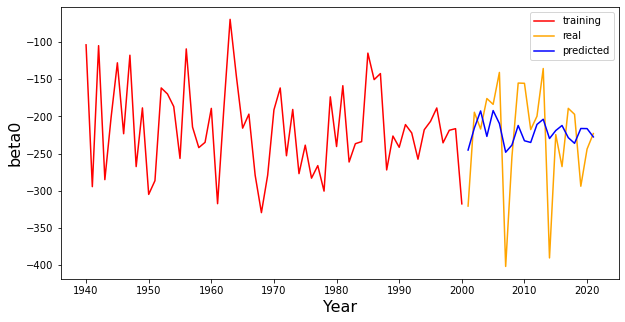

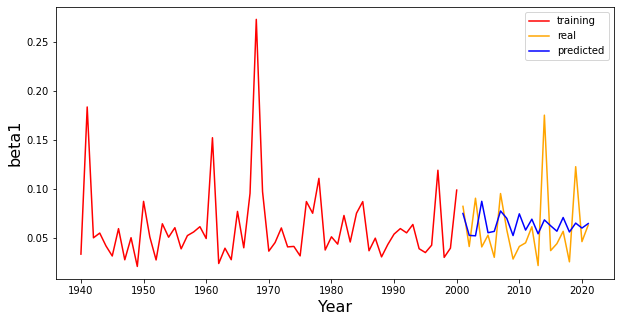

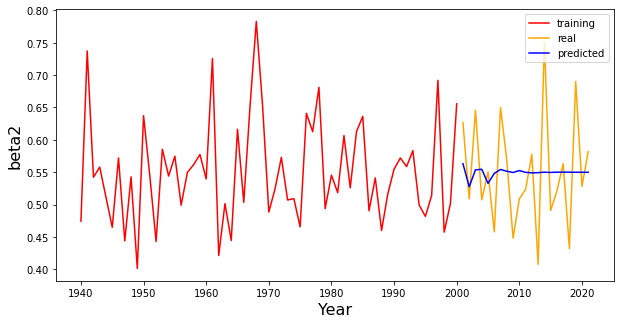

In [28]:
start = 1940
end = 2000
result_val = p_doy_bound(2001, 2021)
x = np.arange(start, end + 1)
x_v = np.arange(2001, 2021 + 1)
plt.figure(figsize=(10, 5))
plt.plot(x, result[2], color = 'red', label = 'training')
plt.plot(x_v, result_val[2], color = 'orange', label = 'real')
plt.plot(np.arange(2001, 2021 + 1), beta0_model.predict(2001-1940, 2021-1940, dynamic=False), 
         color = 'blue', label = 'predicted')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta0", fontsize = 16)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x, result[3], color = 'red', label = 'training')
plt.plot(x_v, result_val[3], color = 'orange', label = 'real')
plt.plot(np.arange(2001, 2021 + 1), beta1_model.predict(2001-1940, 2021-1940, dynamic=False), 
         color = 'blue', label = 'predicted')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta1", fontsize = 16)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x, result[4], color = 'red', label = 'training')
plt.plot(x_v, result_val[4], color = 'orange', label = 'real')
plt.plot(np.arange(2001, 2021 + 1), beta2_model.predict(2001-1940, 2021-1940, dynamic=False), 
         color = 'blue', label = 'predicted')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta2", fontsize = 16)
plt.legend(loc='upper right')
plt.show()

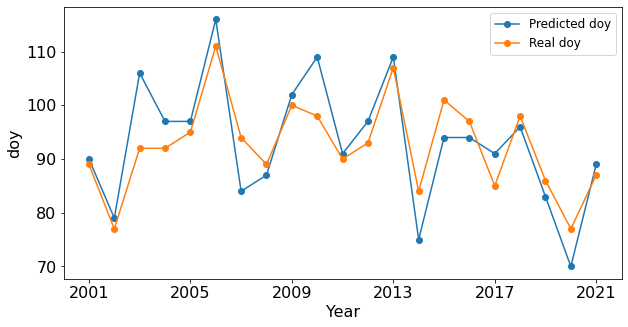

In [29]:
# plot the predict, real doy vs. year
start = 2001
end = 2021
result_pred_ts = predict_blooming_beta_ts(start, end)
x = np.arange(start, end + 1)

f = plt.figure(figsize=(10, 5))
plt.plot(x, result_pred_ts[0], 'o-', label = 'Predicted doy')
plt.plot(x, result_pred_ts[1], 'o-', label = 'Real doy')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("doy", fontsize = 16)
# plt.ylim([67, 115])
plt.xticks(np.arange(2001, 2022, 4), fontsize = 16)
plt.yticks(fontsize = 16)
# plt.title("th = 0.5")
plt.legend(fontsize = 12, loc = 'upper right')
plt.show()
# f.savefig("../result_figures/washington_beta.png", bbox_inches='tight', dpi=1200)
# f.savefig("../result_figures/washington_beta_modified.png", bbox_inches='tight', dpi=1200)

In [22]:
np.array([np.average(train[train['year'] == y-1][-71:]['TAVG']) for y in range(2001, 2022)])

array([7.43091131, 3.71830986, 7.13521127, 4.32535211, 4.42253521,
       4.32112676, 6.94366197, 3.7       , 4.12957746, 6.0084507 ,
       3.63380282, 6.29859155, 5.37183099, 5.34084507, 6.40985915,
       7.63802817, 4.20140845, 5.11408451, 5.96197183, 6.36478873,
       6.26197183])